# Classification Metric : Development & Test

## General

### Imports

In [253]:
import pyvdirs.dirs as dirs
import sys
import os
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

import copy
import pickle
import builtins
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyvtools.text as vtext
import math

import ToyExample.toy_example as toy
import mandala_exploration.fractal_step_by_step as mand
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters

In [254]:
# Network parameters
classes='A'
num_layers=4
hidden_dim=64
batch_size=4<<10
total_iter=4<<10

# Distribution parameters
P_mean=-2.3
P_std=1.5
sigma_data=0.5
sigma_max=5
lr_ref=1e-2
lr_iter=512
ema_std=0.010

# Guidance parameters
guidance=False
guidance_weight=3
guide_path=os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "Ref", "iter0512.pkl")
guide_interpolation=False

# ACID parameters
acid=False
acid_n=16
acid_f=0.8
acid_diff=True
acid_inverted=False

# Training parameters
val_batch_size=4<<7
test_batch_size=4<<8

# Other parameters
device=torch.device('cuda')
fig1_kwargs = dict(view_x=0.30, view_y=0.30, view_size=1.2, device=device)
fig2_kwargs = dict(view_x=0.45, view_y=1.22, view_size=0.3, device=device)#, sample_distance=0.045, sigma_max=0.03)
seed=0

In [255]:
# Set random seed, if specified
if seed is not None:
    print("Seed = ", seed)
    torch.manual_seed(seed)
    generator = torch.Generator(device).manual_seed(seed)
    np.random.seed(seed)

Seed =  0


In [256]:
# Initialize models
gtd, gtd_comps = toy.gt(classes, device)
net = toy.ToyModel(num_layers=num_layers, hidden_dim=hidden_dim, sigma_data=sigma_data).to(device).train().requires_grad_(True)
ema = copy.deepcopy(net).eval().requires_grad_(False)
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.99))
if guide_path is not None:
    with builtins.open(guide_path, "rb") as f:
        guide = pickle.load(f).to(device)
    print("Guide model loaded")
else:
    guide = None
if guidance and acid:
    ref = guide
    print("Guide model assigned as ACID reference")
elif acid: 
    ref = ema
    print("EMA assigned as ACID reference")
else: ref = None

Guide model loaded


## Plots

In [6]:
print("Original threshold for logp is set to", -2.12, "meaning probability density of", math.exp(-2.12))

Original threshold for logp is set to -2.12 meaning probability density of 0.12003162851145673


In [7]:
gtd_comps

[{'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.02134411, 0.06333431]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.05188869, 0.09552517]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.08243328, 0.12771604]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.11297786, 0.1599069 ]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.14352244, 0.19209777]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.17406703, 0.22428864]),
  'Sigma': array

Point (x,y) : log(PDF(x,y)) : PDF(x,y)
(0.3, 0.3) : 2.0693705081939697 : 7.9198360764480915
(0.2, 0.2) : 0.48671233654022217 : 1.6269585255381334
(0.3, 0.2) : -16.56256103515625 : 6.411669624112501e-08
(0.4, 0.2) : -3.1475229263305664 : 0.042958406318854316
(0.3, 0.1) : -56.93898391723633 : 1.8694483878925558e-25


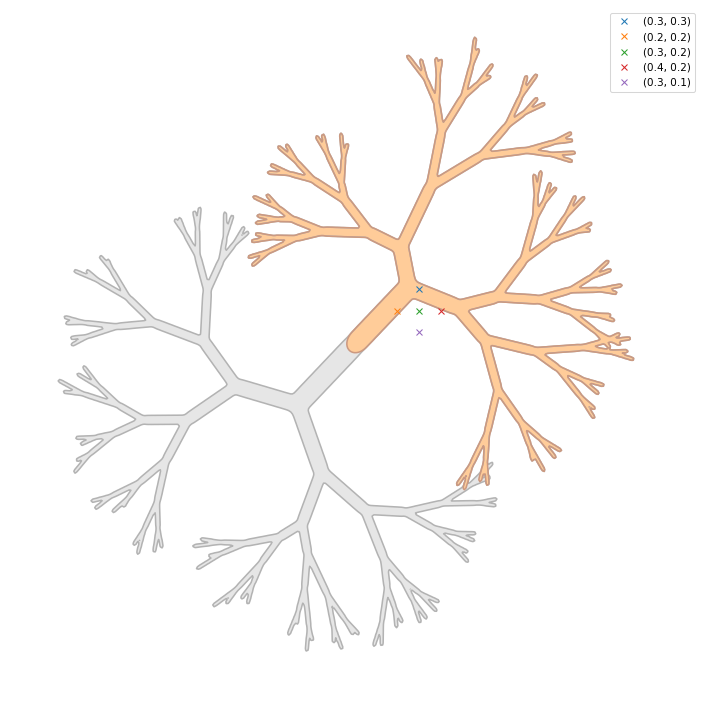

In [ ]:
points = [(.3,.3), (.2,.2), (.3,.2), (.4,.2), (.3,.1)]

fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline'}, ax=ax, device=device)
print("Point (x,y) : log(PDF(x,y)) : PDF(x,y)")
for p in points:
    gt_logp = float(gtd.logp(torch.Tensor(p).reshape((1,2)).to(device)))
    print(p, ":", gt_logp, ":", math.exp(gt_logp))
    plt.plot(*p,"x",label=str(p))
plt.legend()

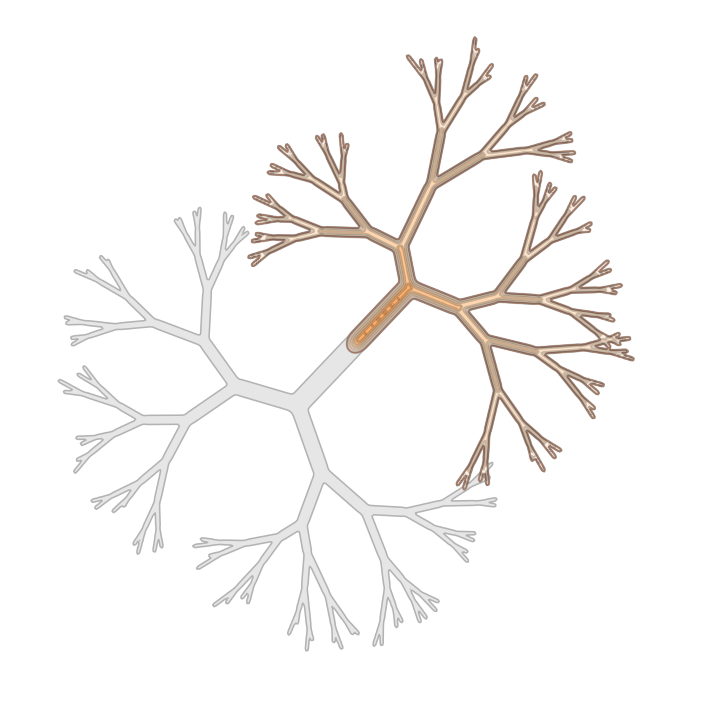

In [10]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline', 'gt_shaded'}, ax=ax, device=device)

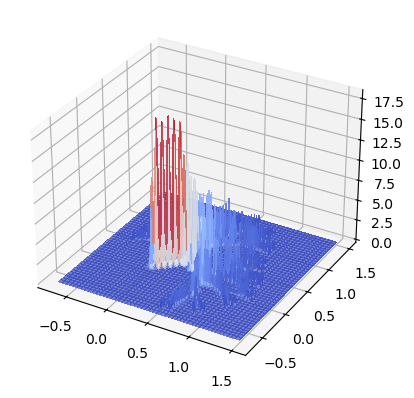

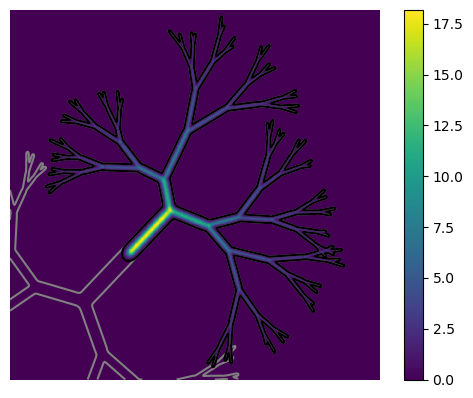

In [5]:
grid_resolution = 801
zoom_out = 1

x_centre = .4
y_centre = .4
y_side = x_side = 2*1.1

samples = utils.create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)
f_samples = gtd.pdf(samples)

samples = samples.swapaxes(0,2).swapaxes(1,2).cpu().numpy()
f_samples = f_samples.detach().cpu().numpy()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(*samples, f_samples, cmap="coolwarm", 
                linewidth=0, antialiased=False, alpha=0.7)

fig, ax = plt.subplots()
plt.pcolormesh(*samples, f_samples)
ax.set_aspect("equal")
plt.colorbar()
toy.do_plot(ema, elems={'gt_uncond_transparent', 'gt_outline_transparent'}, ax=ax, 
            view_x=x_centre, view_y=y_centre, view_size=x_side/2)

## Old plots

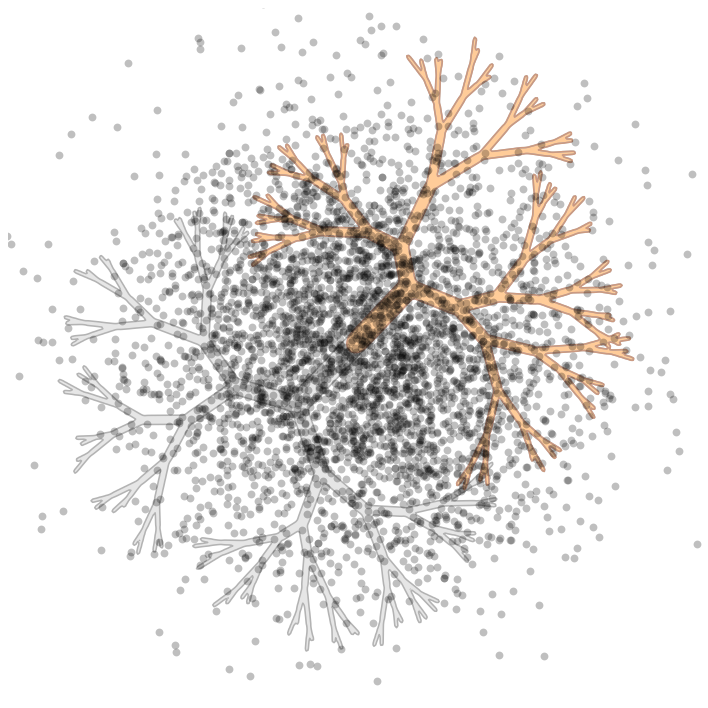

In [12]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples','gt_uncond', 'gt_outline'}, ax=ax,
            sigma_max=sigma_max, device=device, num_samples=1<<12)

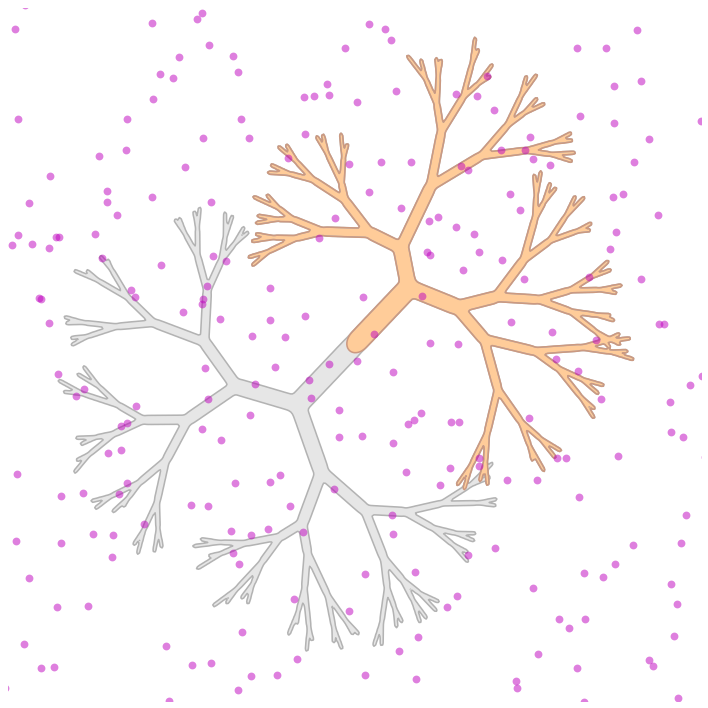

In [13]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, ax=ax, num_samples=1<<12)

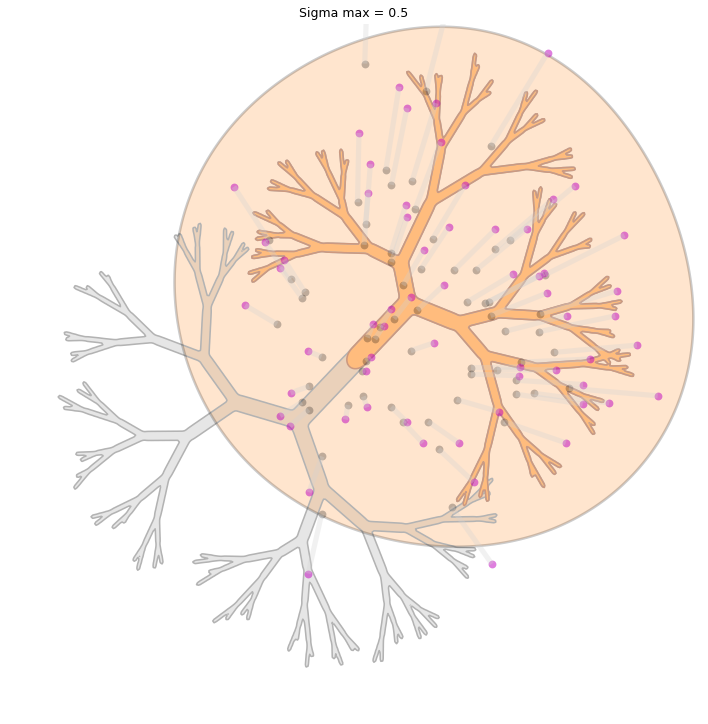

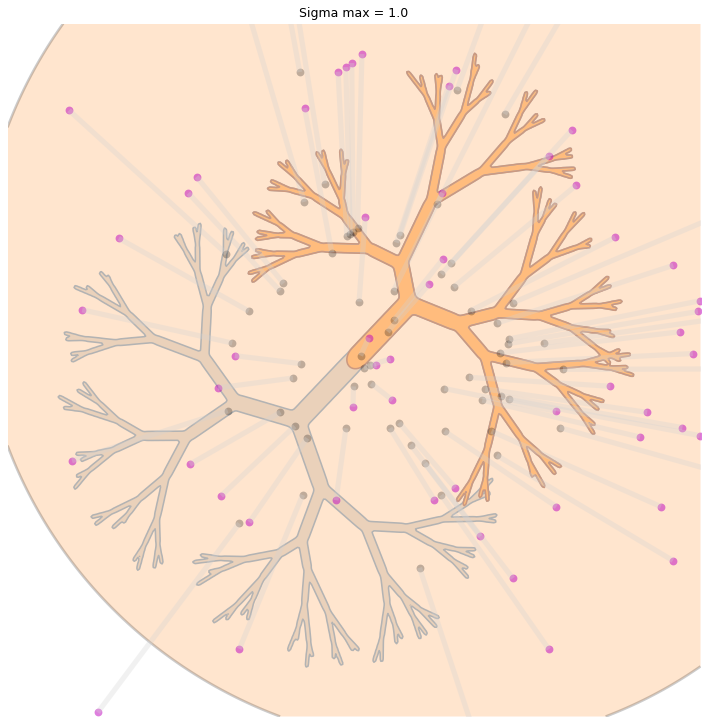

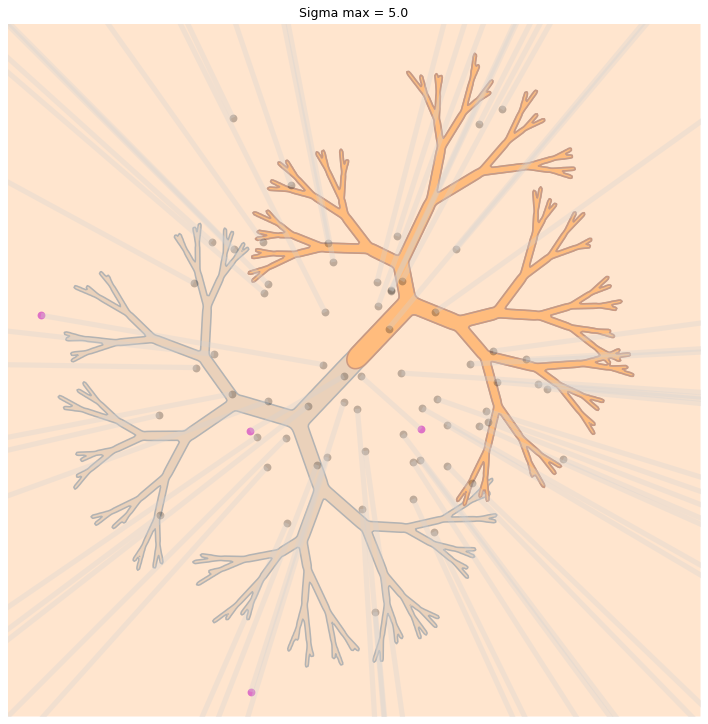

In [14]:
for sigma_max in [0.5,1,5]:
    fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
    toy.do_plot(ema, elems={'samples_before_small',
                            'trajectories_small', 'samples',
                            'gt_smax',
                            'gt_uncond', 'gt_outline'}, 
                num_samples=1<<6, sigma_max=sigma_max, ax=ax)
    plt.title(f"Sigma max = {sigma_max:.1f}")

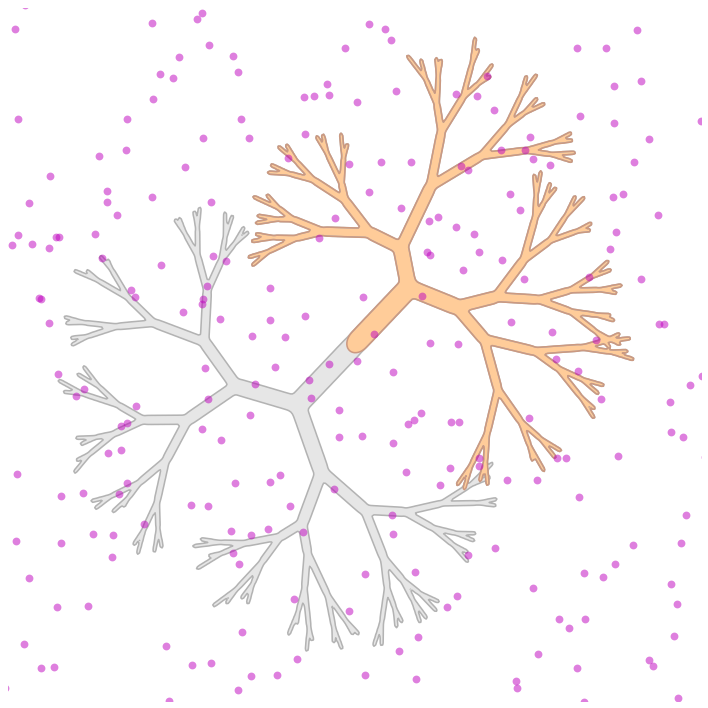

In [16]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, num_samples=1<<12, ax=ax)

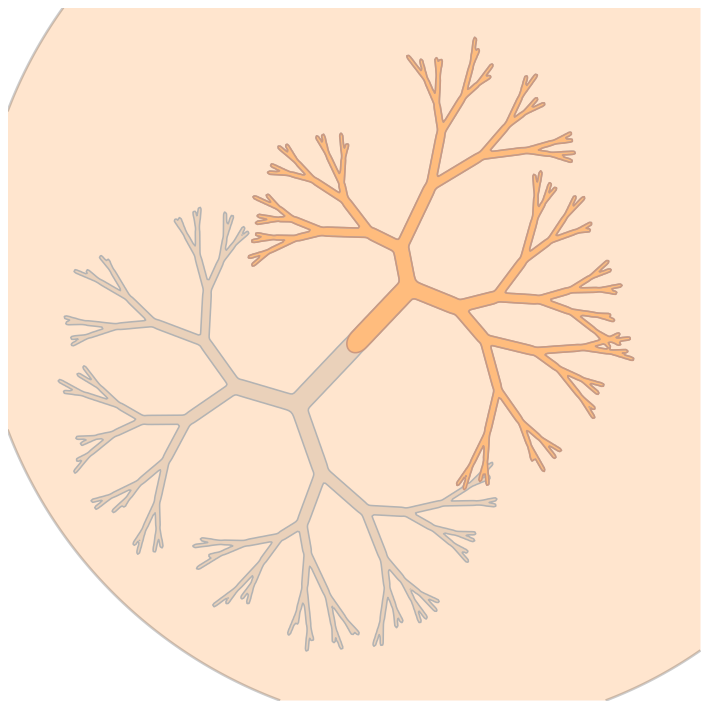

In [17]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_smax','gt_uncond', 'gt_outline'}, num_samples=1<<12, sigma_max=1, ax=ax)

## Mandala score

In [ ]:
def mandala_score(model, ground_truth_dist, guide=None, guidance_weight=1,
                  n_samples=500, sigma_max=5,
                  grid_resolution=101, 
                  x_centre=toy.GT_ORIGIN[0], y_centre=toy.GT_ORIGIN[1], 
                  x_side=2*1.5, y_side=2*1.5,
                  logging=False, plotting=True, full_scale=True):

    # Create samples
    if isinstance(model, toy.GaussianMixture):
        net_samples = gtd.sample(n_samples, sigma=0)
    else:
        gt_samples = gtd.sample(n_samples, sigma=sigma_max)
        net_samples = toy.do_sample(net=model, gnet=guide, guidance=guidance_weight,
                                    x_init=gt_samples, sigma_max=sigma_max)[-1]

    # Create grid
    grid_coords = utils.create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)
    cell_size, bounds = utils.get_grid_params(grid_resolution, x_centre, y_centre, x_side, y_side)
    cell_size = cell_size[0] # Squared symmetric grid ==> Retain just one
    x_edges = np.linspace(*bounds[0], grid_resolution+1)
    y_edges = np.linspace(*bounds[1], grid_resolution+1)

    # Discard samples that fell off the grid
    net_samples = net_samples[net_samples[:,0]>=bounds[0][0]]
    net_samples = net_samples[net_samples[:,0]<=bounds[0][1]]
    net_samples = net_samples[net_samples[:,1]>=bounds[1][0]]
    net_samples = net_samples[net_samples[:,1]<=bounds[1][1]]
    n_in_grid = len(net_samples)

    # Count hits and misses
    hit_samples_mask = utils.is_sample_in_fractal(net_samples, ground_truth_dist)
    n_hits = int(torch.sum(hit_samples_mask))
    n_miss = n_in_grid - n_hits
    if logging: print("Total in grid", n_in_grid, "\n> Hits", n_hits, "\n> Misses", n_miss)
    hit_samples = net_samples[hit_samples_mask]
    miss_samples = net_samples[torch.logical_not(hit_samples_mask)]

    # Calculate non-unique metric
    non_unique_score = n_hits / n_samples
    if logging: print("Initial score", non_unique_score)

    # Get grid coordinates for hits and misses
    hit_cells = np.array( mand.point_to_cell(hit_samples, 
                                             bounds[0][0], bounds[1][0], 
                                             cell_size, xy_order=True ), dtype=np.int32 ).T
    miss_cells = np.array( mand.point_to_cell(miss_samples, 
                                              bounds[0][0], bounds[1][0], 
                                              cell_size, xy_order=True ), dtype=np.int32 ).T

    # Register hits and missess in a plottable grid
    grid = np.zeros((grid_resolution, grid_resolution))
    for cell in hit_cells: grid[*cell] += 1
    for cell in miss_cells: grid[*cell] -= 1

    # Get unique hits and misses
    hit_unique = set([(x,y) for x,y in hit_cells])
    miss_unique = set([(x,y) for x,y in miss_cells])
    n_hits_unique = len(hit_unique)
    n_miss_unique = len(miss_unique)
    n_unique = n_hits_unique+n_miss_unique
    if logging: print("Unique total in grid", n_unique, "\n> Unique hits", n_hits_unique, 
                      "\n> Unique misses", n_miss_unique)

    # Calculate metric    
    mandala_score = n_hits_unique / n_unique if n_unique > 0 else 0
    if logging: print("Mandala score", mandala_score)    

    if plotting:
            
        # Create figure with square aspect ratio
        plt.figure(figsize=(10, 5), dpi=300)

        # 1. Draw fractal with scatter
        ax1 = plt.subplot(121, aspect='equal')
        ax1.set_title("Fractal Tree with Scatter")

        # Draw fractal
        toy.do_plot(ema, elems={'gt_uncond', 'gt_outline'},
                    view_x=x_centre, view_y=y_centre, view_size=x_side/2, ax=ax1)

        # Plot scatter points
        ax1.scatter(*net_samples.swapaxes(0,1).detach().cpu().numpy(), color='k', alpha=0.1, s=10, zorder=10)

        # 2. Hit/Miss Visualization
        ax2 = plt.subplot(122, aspect='equal')
        ax2.set_title("Hit/Miss Analysis")

        if full_scale:
            grid_to_plot = grid
            cmap="seismic"
        else:
            grid_to_plot = grid
            grid_to_plot[grid_to_plot>1]=4
            grid_to_plot[grid_to_plot<-1]=-4
            cmap="bwr"
        ax2.pcolormesh(*grid_coords.swapaxes(0,2).detach().cpu().numpy(), 
                        grid_to_plot.T, cmap=cmap, 
                        vmin=-max(abs(grid.min()), abs(grid.max())), 
                        vmax=max(abs(grid.min()), abs(grid.max())), 
                        alpha=1)
        toy.do_plot(ema, elems={'gt_uncond_thin', 'gt_outline_thin'},
                    view_x=x_centre, view_y=y_centre, view_size=x_side/2, ax=ax2)

        # Add thin grid lines
        for x in x_edges:
            ax2.axvline(x=x, color='gray', alpha=0.2, linewidth=0.1)
        for y in y_edges:
            ax2.axhline(y=y, color='gray', alpha=0.2, linewidth=0.1)

        # Set bounds and remove axis numbers for all plots
        for ax in [ax1, ax2]:
            ax.set_xlim(*bounds[0])
            ax.set_ylim(*bounds[1])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        plt.tight_layout()

        # Add stats only to the last plot
        stats_text = f"Ground Truth: {n_unique}\nHits: {n_hits_unique}\nMisses: {n_miss_unique}"\
            f"\nMandala Score: {mandala_score:.3f}"
        ax2.text(0.02, 0.98, stats_text,
                    transform=ax2.transAxes,
                    verticalalignment='top',
                    fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return mandala_score, non_unique_score

### Ground truth test

Total in grid 512 
> Hits 510 
> Misses 2
Initial score 0.99609375
Unique total in grid 274 
> Unique hits 272 
> Unique misses 2
Mandala score 0.9927007299270073


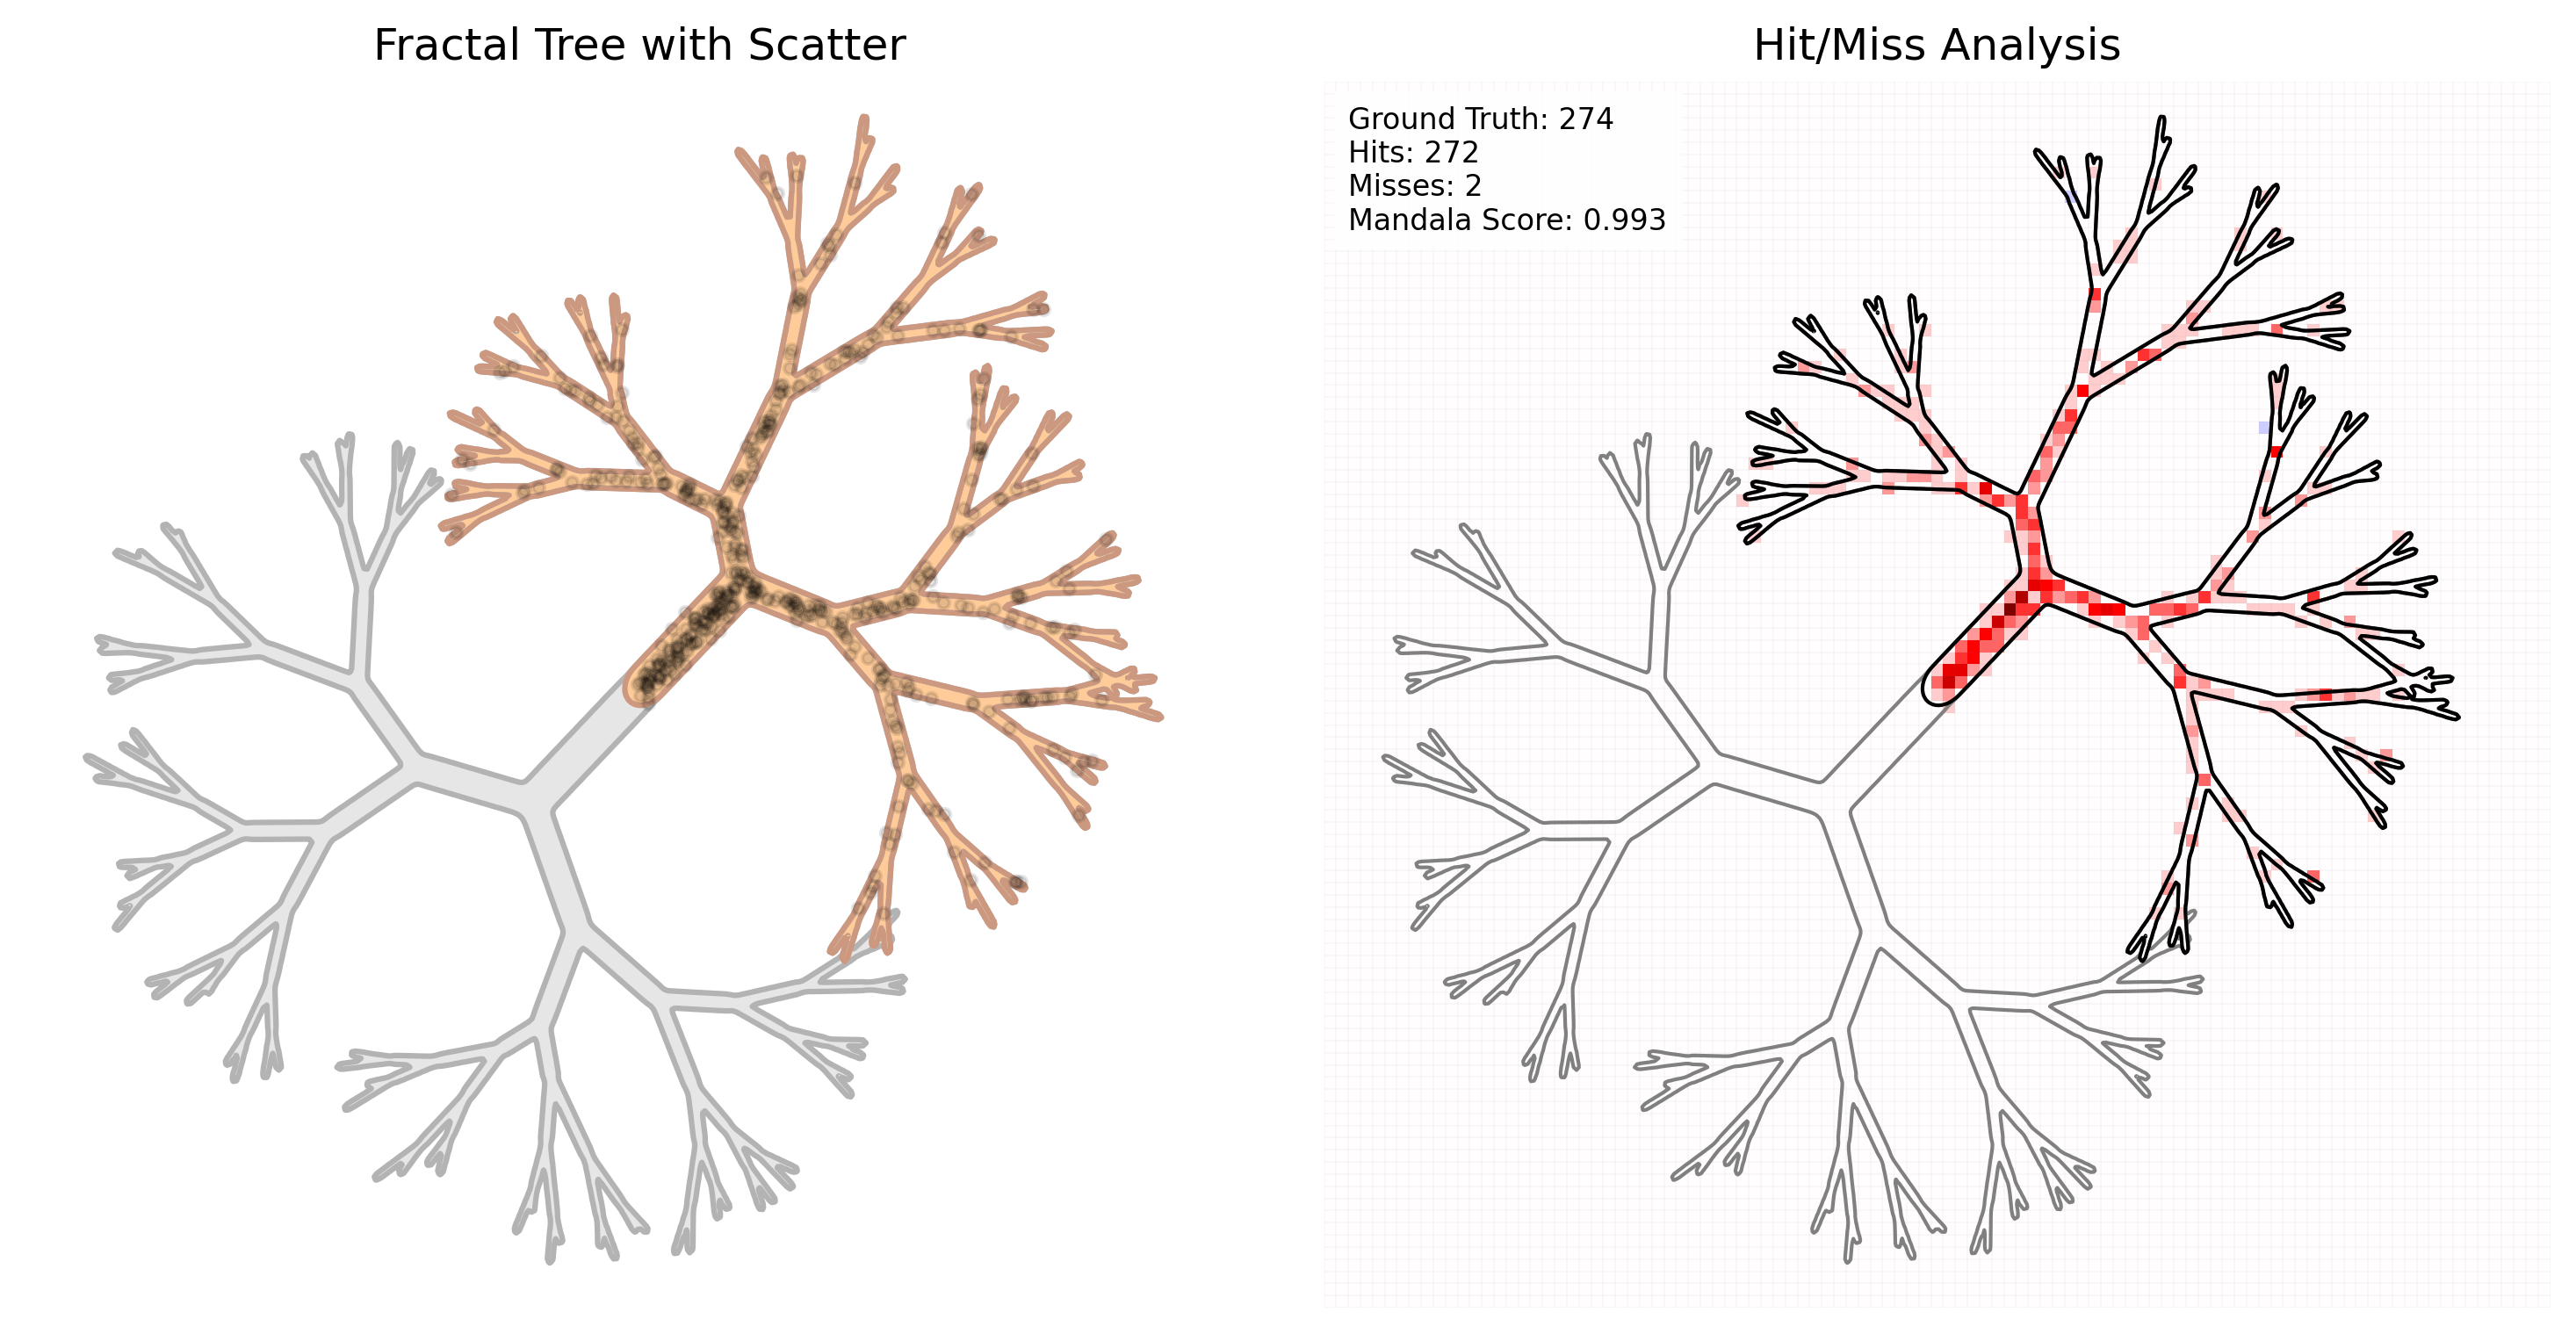

In [258]:
# Parameters
grid_resolution = 101
n_samples = 512

mandala_score(gtd, gtd, n_samples=n_samples, sigma_max=sigma_max,
              grid_resolution=grid_resolution,
              logging=True, plotting=True)
plt.savefig(os.path.join(dirs.RESULTS_HOME, 'fractal_analysis_gt_2.png'), dpi=300, bbox_inches='tight')

#### Trimmed scale

Total in grid 512 
> Hits 509 
> Misses 3
Unique total in grid 273 
> Unique hits 270 
> Unique misses 3
Mandala score 0.989010989010989


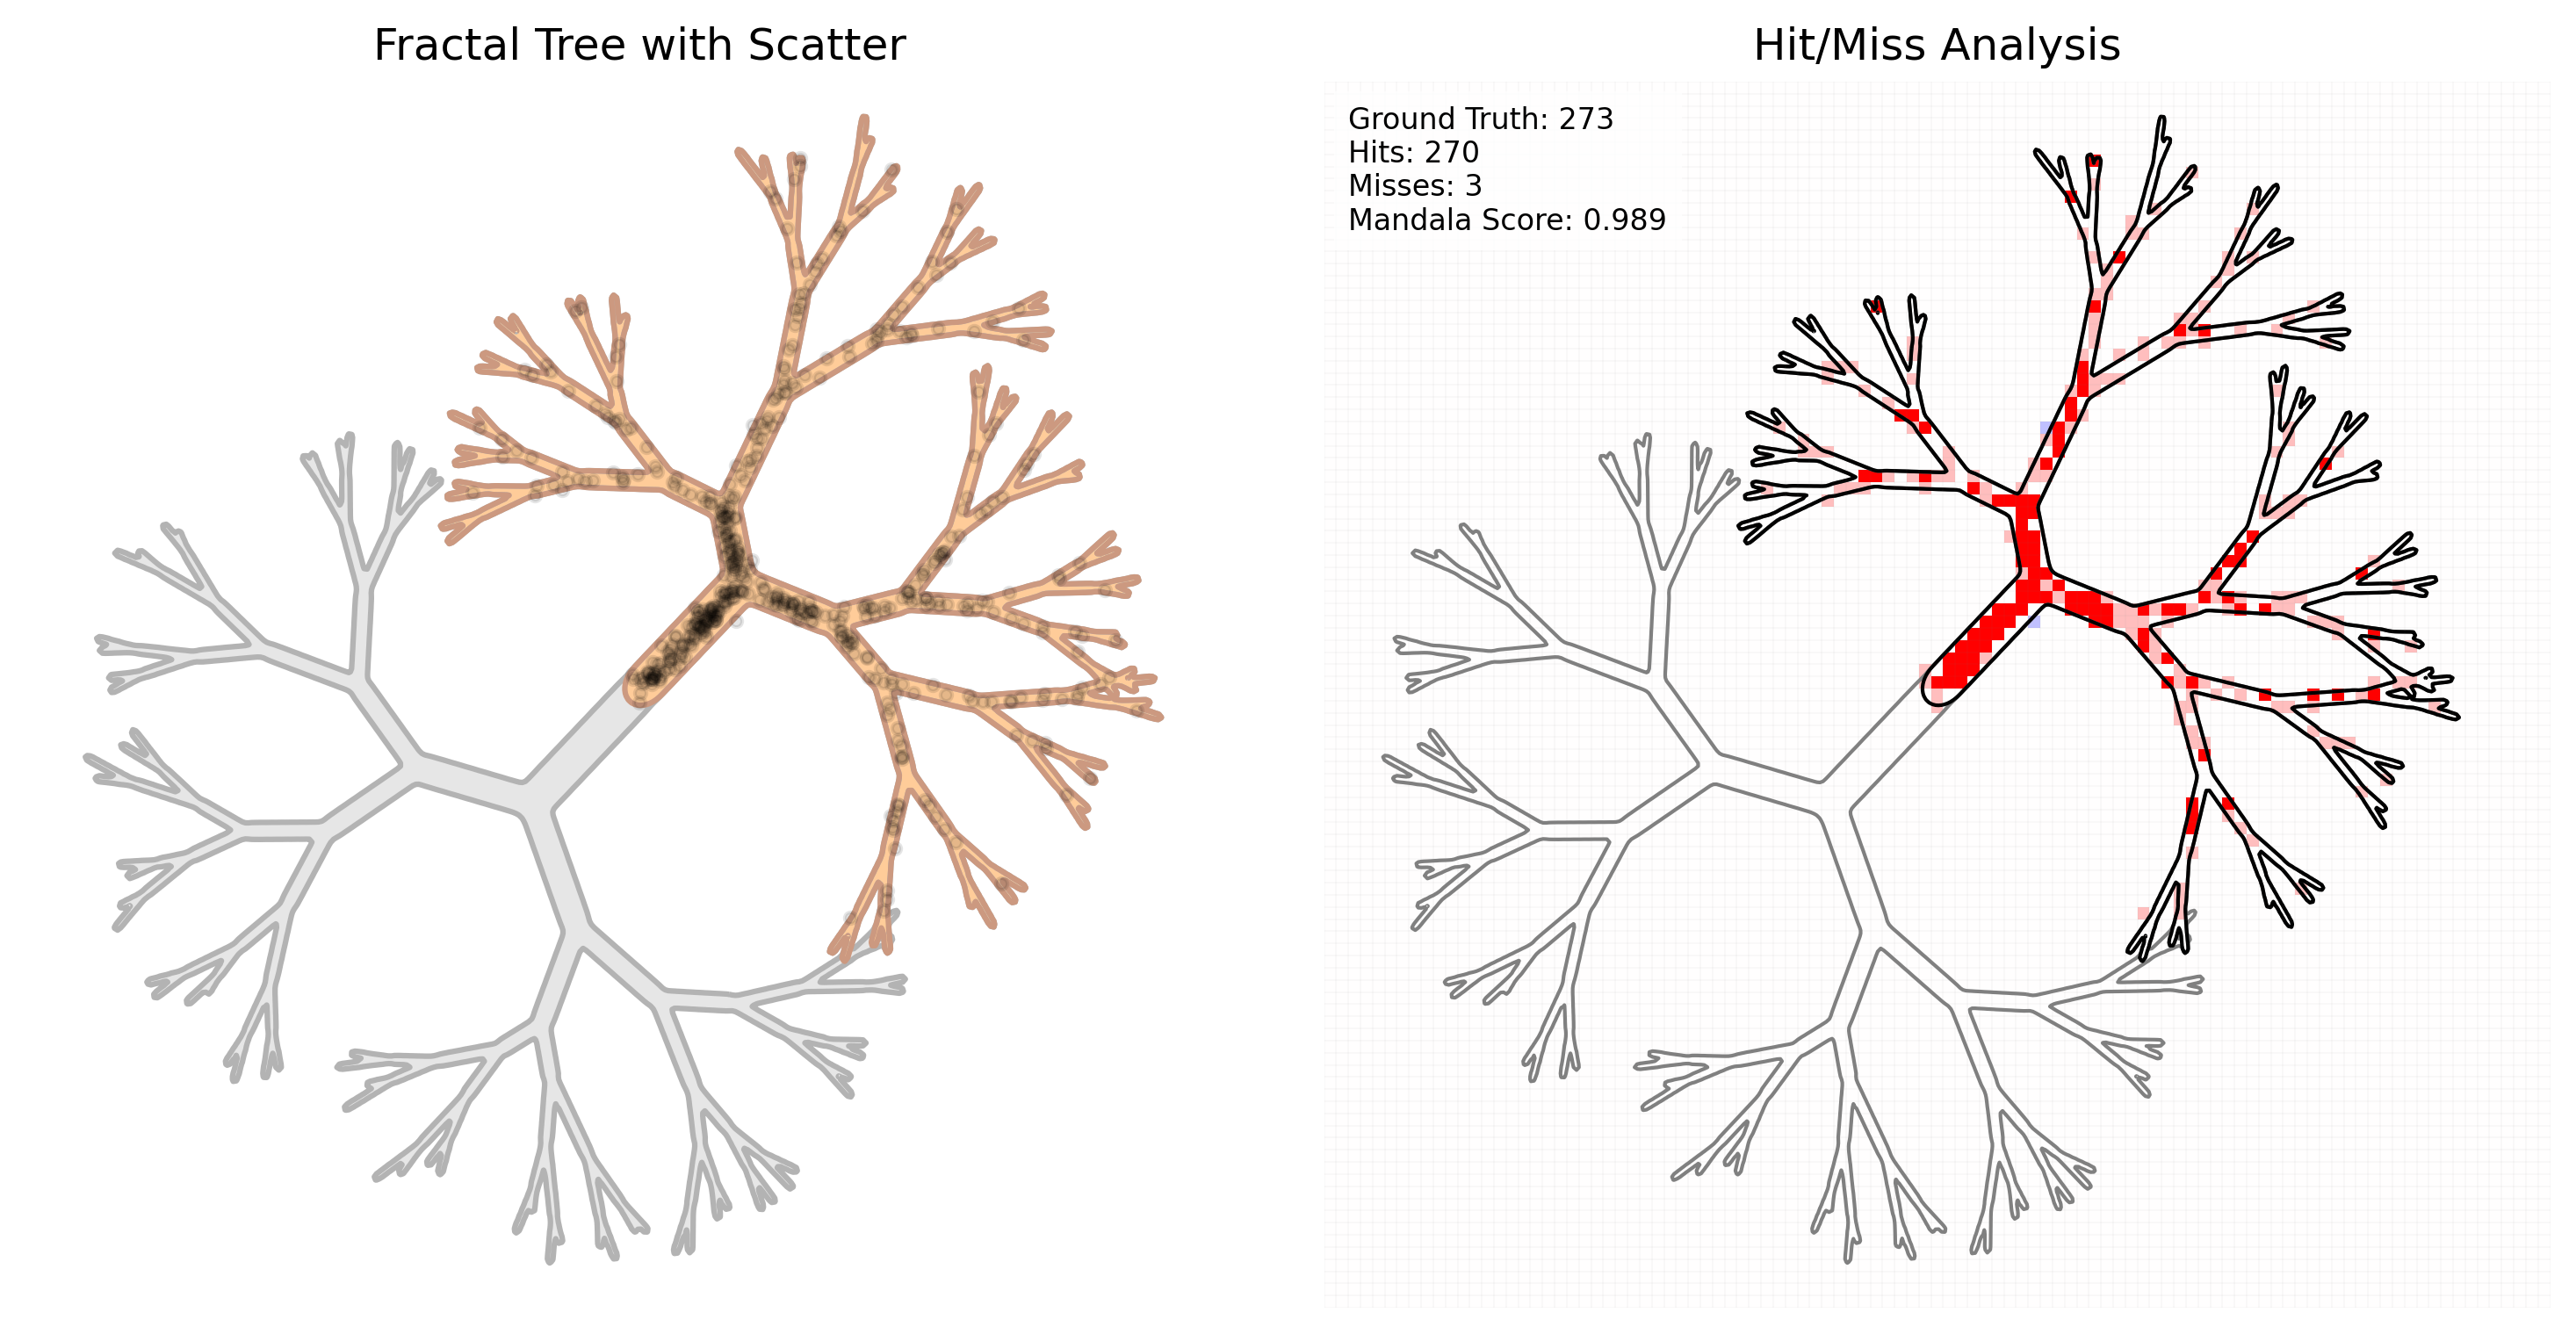

In [ ]:
# Parameters
grid_resolution = 101
n_samples = 512

mandala_score(gtd, gtd, n_samples=n_samples, sigma_max=sigma_max,
              grid_resolution=grid_resolution,
              logging=True, plotting=True, full_scale=False)
plt.savefig(os.path.join(dirs.RESULTS_HOME, 'fractal_analysis_gt_partial_2.png'), dpi=300, bbox_inches='tight')

#### Test vs number of samples

In [260]:
# Parameters
grid_resolution = 101
n_samples = [2**n for n in range(8,16)]

mandala_results = []
non_unique_results = []

for n in n_samples:
    mand_score, non_unique_score = mandala_score(
        gtd, gtd, n_samples=n, sigma_max=sigma_max,
        grid_resolution=grid_resolution,
        logging=True, plotting=False)
    mandala_results.append( mand_score )
    non_unique_results.append( non_unique_score )

Total in grid 256 
> Hits 254 
> Misses 2
Initial score 0.9921875
Unique total in grid 166 
> Unique hits 164 
> Unique misses 2
Mandala score 0.9879518072289156
Total in grid 512 
> Hits 510 
> Misses 2
Initial score 0.99609375
Unique total in grid 258 
> Unique hits 256 
> Unique misses 2
Mandala score 0.9922480620155039
Total in grid 1024 
> Hits 1014 
> Misses 10
Initial score 0.990234375
Unique total in grid 386 
> Unique hits 377 
> Unique misses 9
Mandala score 0.9766839378238342
Total in grid 2048 
> Hits 2032 
> Misses 16
Initial score 0.9921875
Unique total in grid 530 
> Unique hits 514 
> Unique misses 16
Mandala score 0.969811320754717
Total in grid 4096 
> Hits 4061 
> Misses 35
Initial score 0.991455078125
Unique total in grid 680 
> Unique hits 646 
> Unique misses 34
Mandala score 0.95
Total in grid 8192 
> Hits 8134 
> Misses 58
Initial score 0.992919921875
Unique total in grid 794 
> Unique hits 737 
> Unique misses 57
Mandala score 0.9282115869017632
Total in grid 1

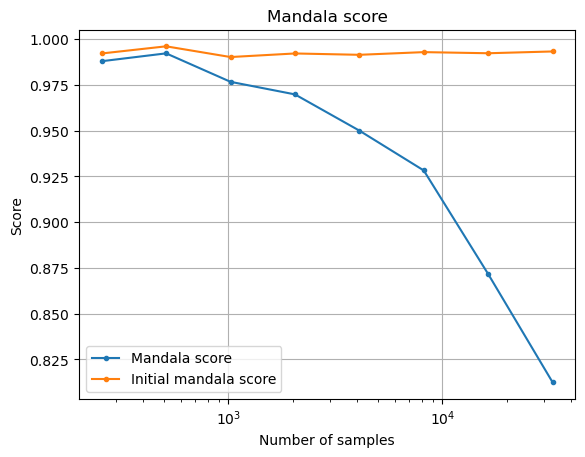

In [261]:
fig, ax = plt.subplots()
plt.plot(n_samples, mandala_results, ".-")
plt.plot(n_samples, non_unique_results, ".-")
plt.ylabel("Score");
plt.xlabel("Number of samples");
plt.grid()
plt.legend(["Mandala score", "Initial mandala score"])
plt.title(f"Mandala score");
ax.set_xscale("log")

### Test on untrained model

Total in grid 511 
> Hits 50 
> Misses 461
Initial score 0.09765625
Unique total in grid 480 
> Unique hits 44 
> Unique misses 436
Mandala score 0.09166666666666666


(0.09166666666666666, 0.09765625)

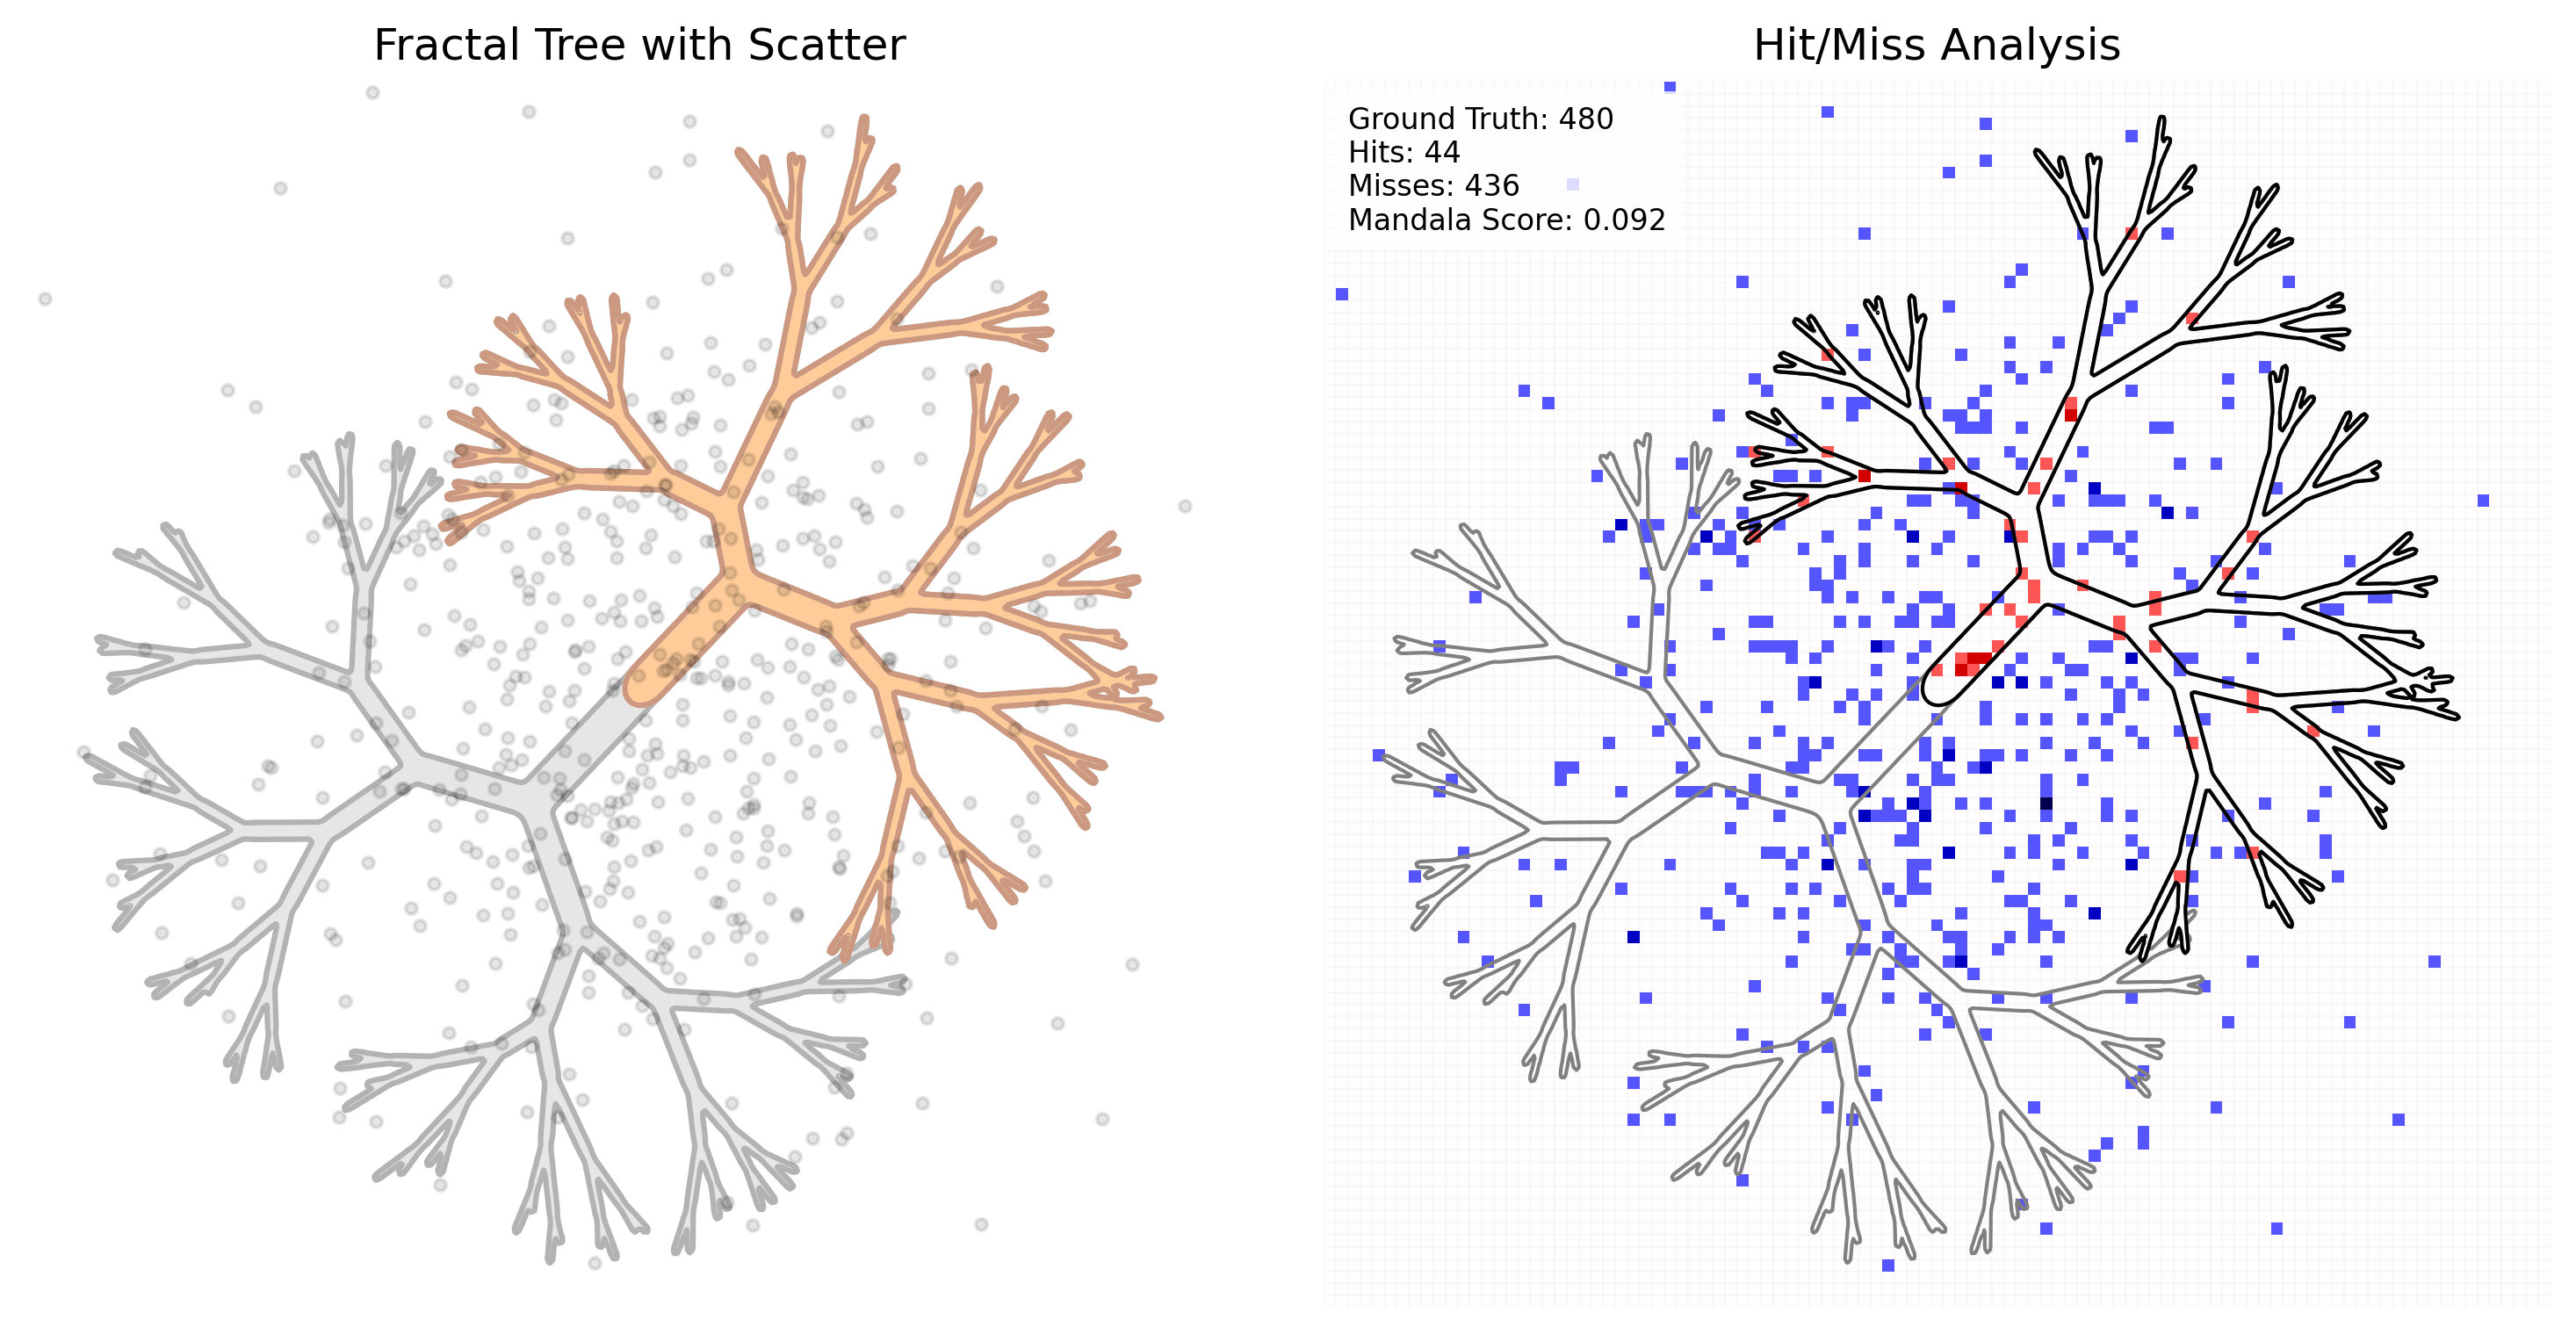

In [252]:
# Parameters
grid_resolution = 101
n_samples = 512

mandala_score(net, gtd, n_samples=n_samples, sigma_max=sigma_max,
              grid_resolution=grid_resolution,
              logging=True, plotting=True)
# plt.savefig(os.path.join(dirs.RESULTS_HOME, 'fractal_analysis_guide_2.png'), dpi=300, bbox_inches='tight')

In [33]:
2**8

256

#### Test vs number of samples

In [ ]:
# Parameters
grid_resolution = 101
n_samples = [2**n for n in range(8,16)]

mandala_results = []
non_unique_results = []

for n in n_samples:
    mand_score, non_unique_score = mandala_score(
        net, gtd, n_samples=n, sigma_max=sigma_max,
        grid_resolution=grid_resolution,
        logging=True, plotting=False)
    mandala_results.append( mand_score )
    non_unique_results.append( non_unique_score )

Total in grid 253 
> Hits 33 
> Misses 220
Initial score 0.12890625
Unique total in grid 244 
> Unique hits 30 
> Unique misses 214
Mandala score 0.12295081967213115
Total in grid 508 
> Hits 56 
> Misses 452
Initial score 0.109375
Unique total in grid 470 
> Unique hits 51 
> Unique misses 419
Mandala score 0.10851063829787234
Total in grid 1023 
> Hits 81 
> Misses 942
Initial score 0.0791015625
Unique total in grid 905 
> Unique hits 74 
> Unique misses 831
Mandala score 0.08176795580110498
Total in grid 2037 
> Hits 189 
> Misses 1848
Initial score 0.09228515625
Unique total in grid 1555 
> Unique hits 140 
> Unique misses 1415
Mandala score 0.09003215434083602
Total in grid 4083 
> Hits 393 
> Misses 3690
Initial score 0.095947265625
Unique total in grid 2622 
> Unique hits 255 
> Unique misses 2367
Mandala score 0.09725400457665904
Total in grid 8159 
> Hits 832 
> Misses 7327
Initial score 0.1015625
Unique total in grid 3747 
> Unique hits 390 
> Unique misses 3357
Mandala score

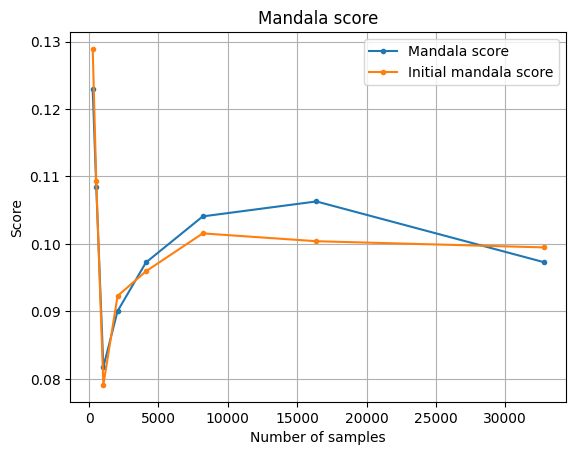

In [ ]:
plt.figure()
plt.plot(n_samples, mandala_results, ".-")
plt.plot(n_samples, non_unique_results, ".-")
plt.ylabel("Score");
plt.xlabel("Number of samples");
plt.grid()
plt.legend(["Mandala score", "Initial mandala score"])
plt.title(f"Mandala score");

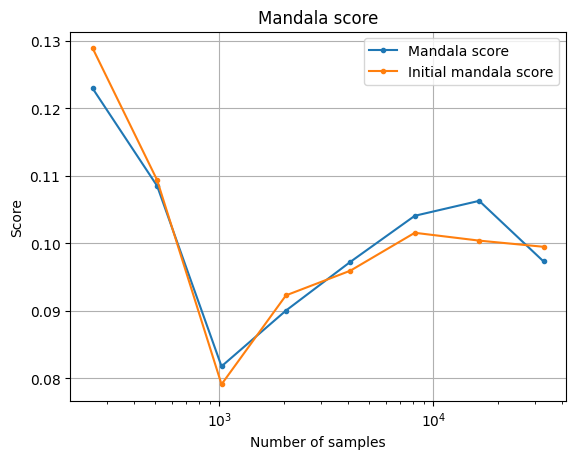

In [ ]:
fig, ax = plt.subplots()
plt.plot(n_samples, mandala_results, ".-")
plt.plot(n_samples, non_unique_results, ".-")
plt.ylabel("Score");
plt.xlabel("Number of samples");
plt.legend(["Mandala score", "Initial mandala score"])
plt.title(f"Mandala score");
ax.set_xscale("log")
plt.grid()

### Test on guide model

Total in grid 511 
> Hits 376 
> Misses 135
Unique total in grid 299 
> Unique hits 173 
> Unique misses 126
Mandala score 0.5785953177257525


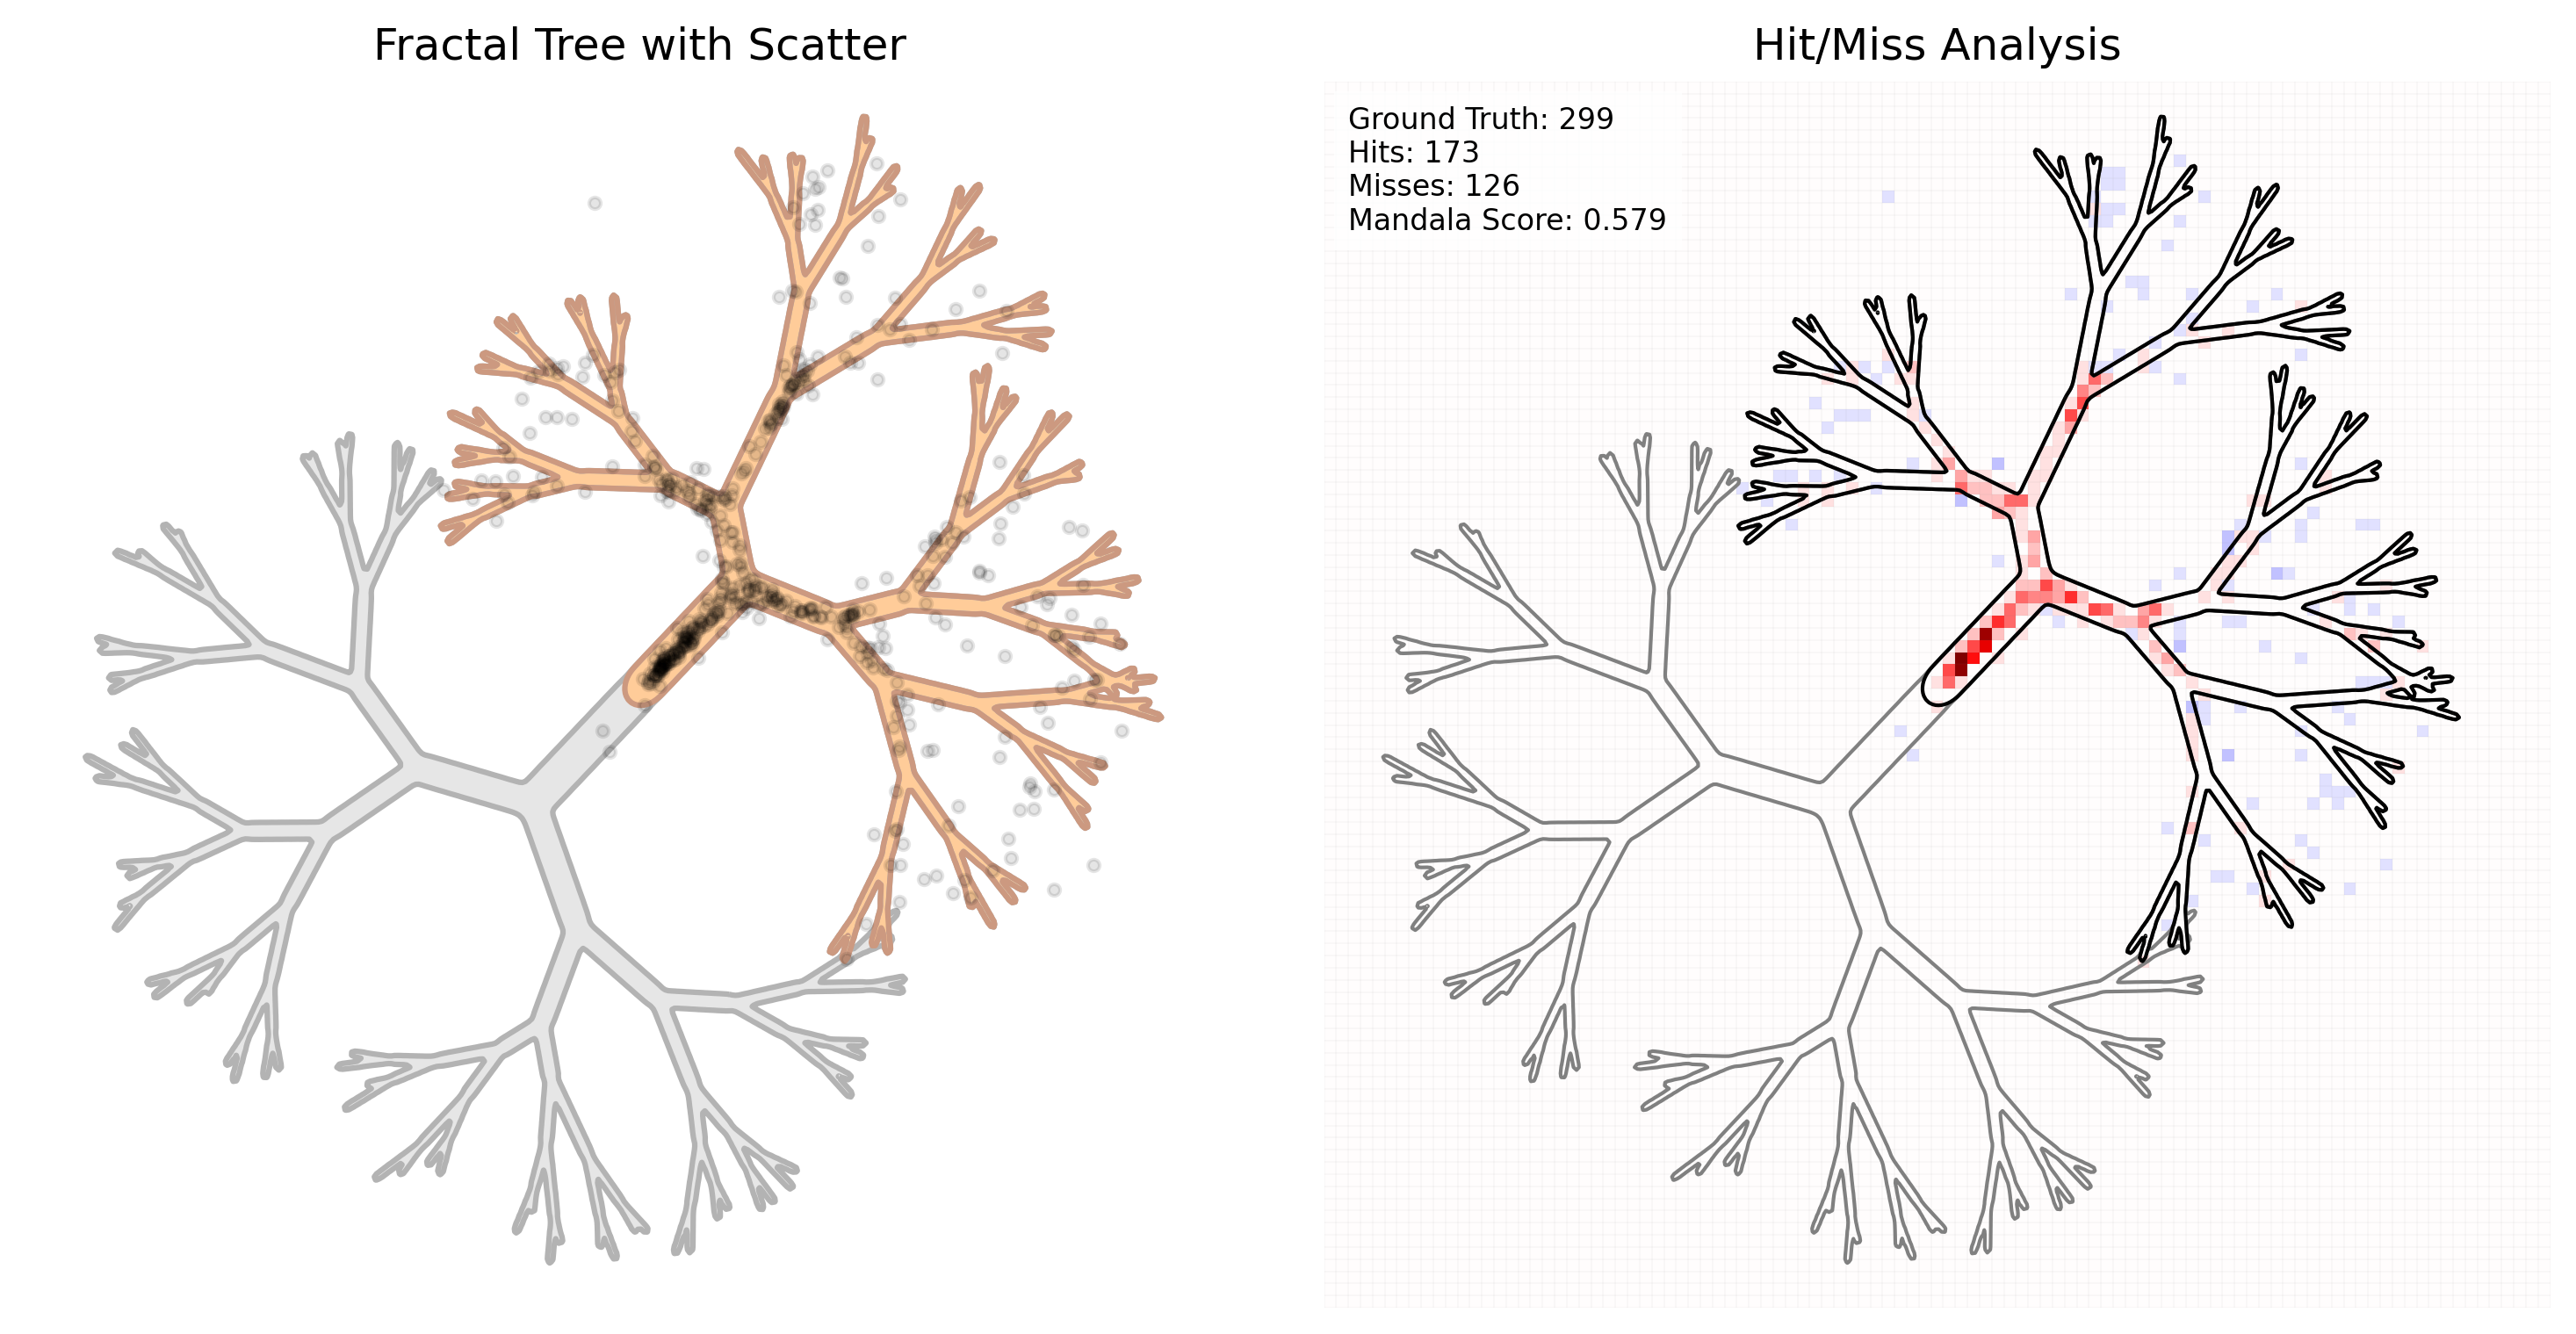

In [234]:
# Parameters
grid_resolution = 101
n_samples = 512

mandala_score(guide, gtd, n_samples=n_samples, sigma_max=sigma_max,
              grid_resolution=grid_resolution,
              logging=True, plotting=True)
plt.savefig(os.path.join(dirs.RESULTS_HOME, 'fractal_analysis_guide_2.png'), dpi=300, bbox_inches='tight')

#### Trimmed scale

Total in grid 511 
> Hits 361 
> Misses 150
Unique total in grid 294 
> Unique hits 162 
> Unique misses 132
Mandala score 0.5510204081632653


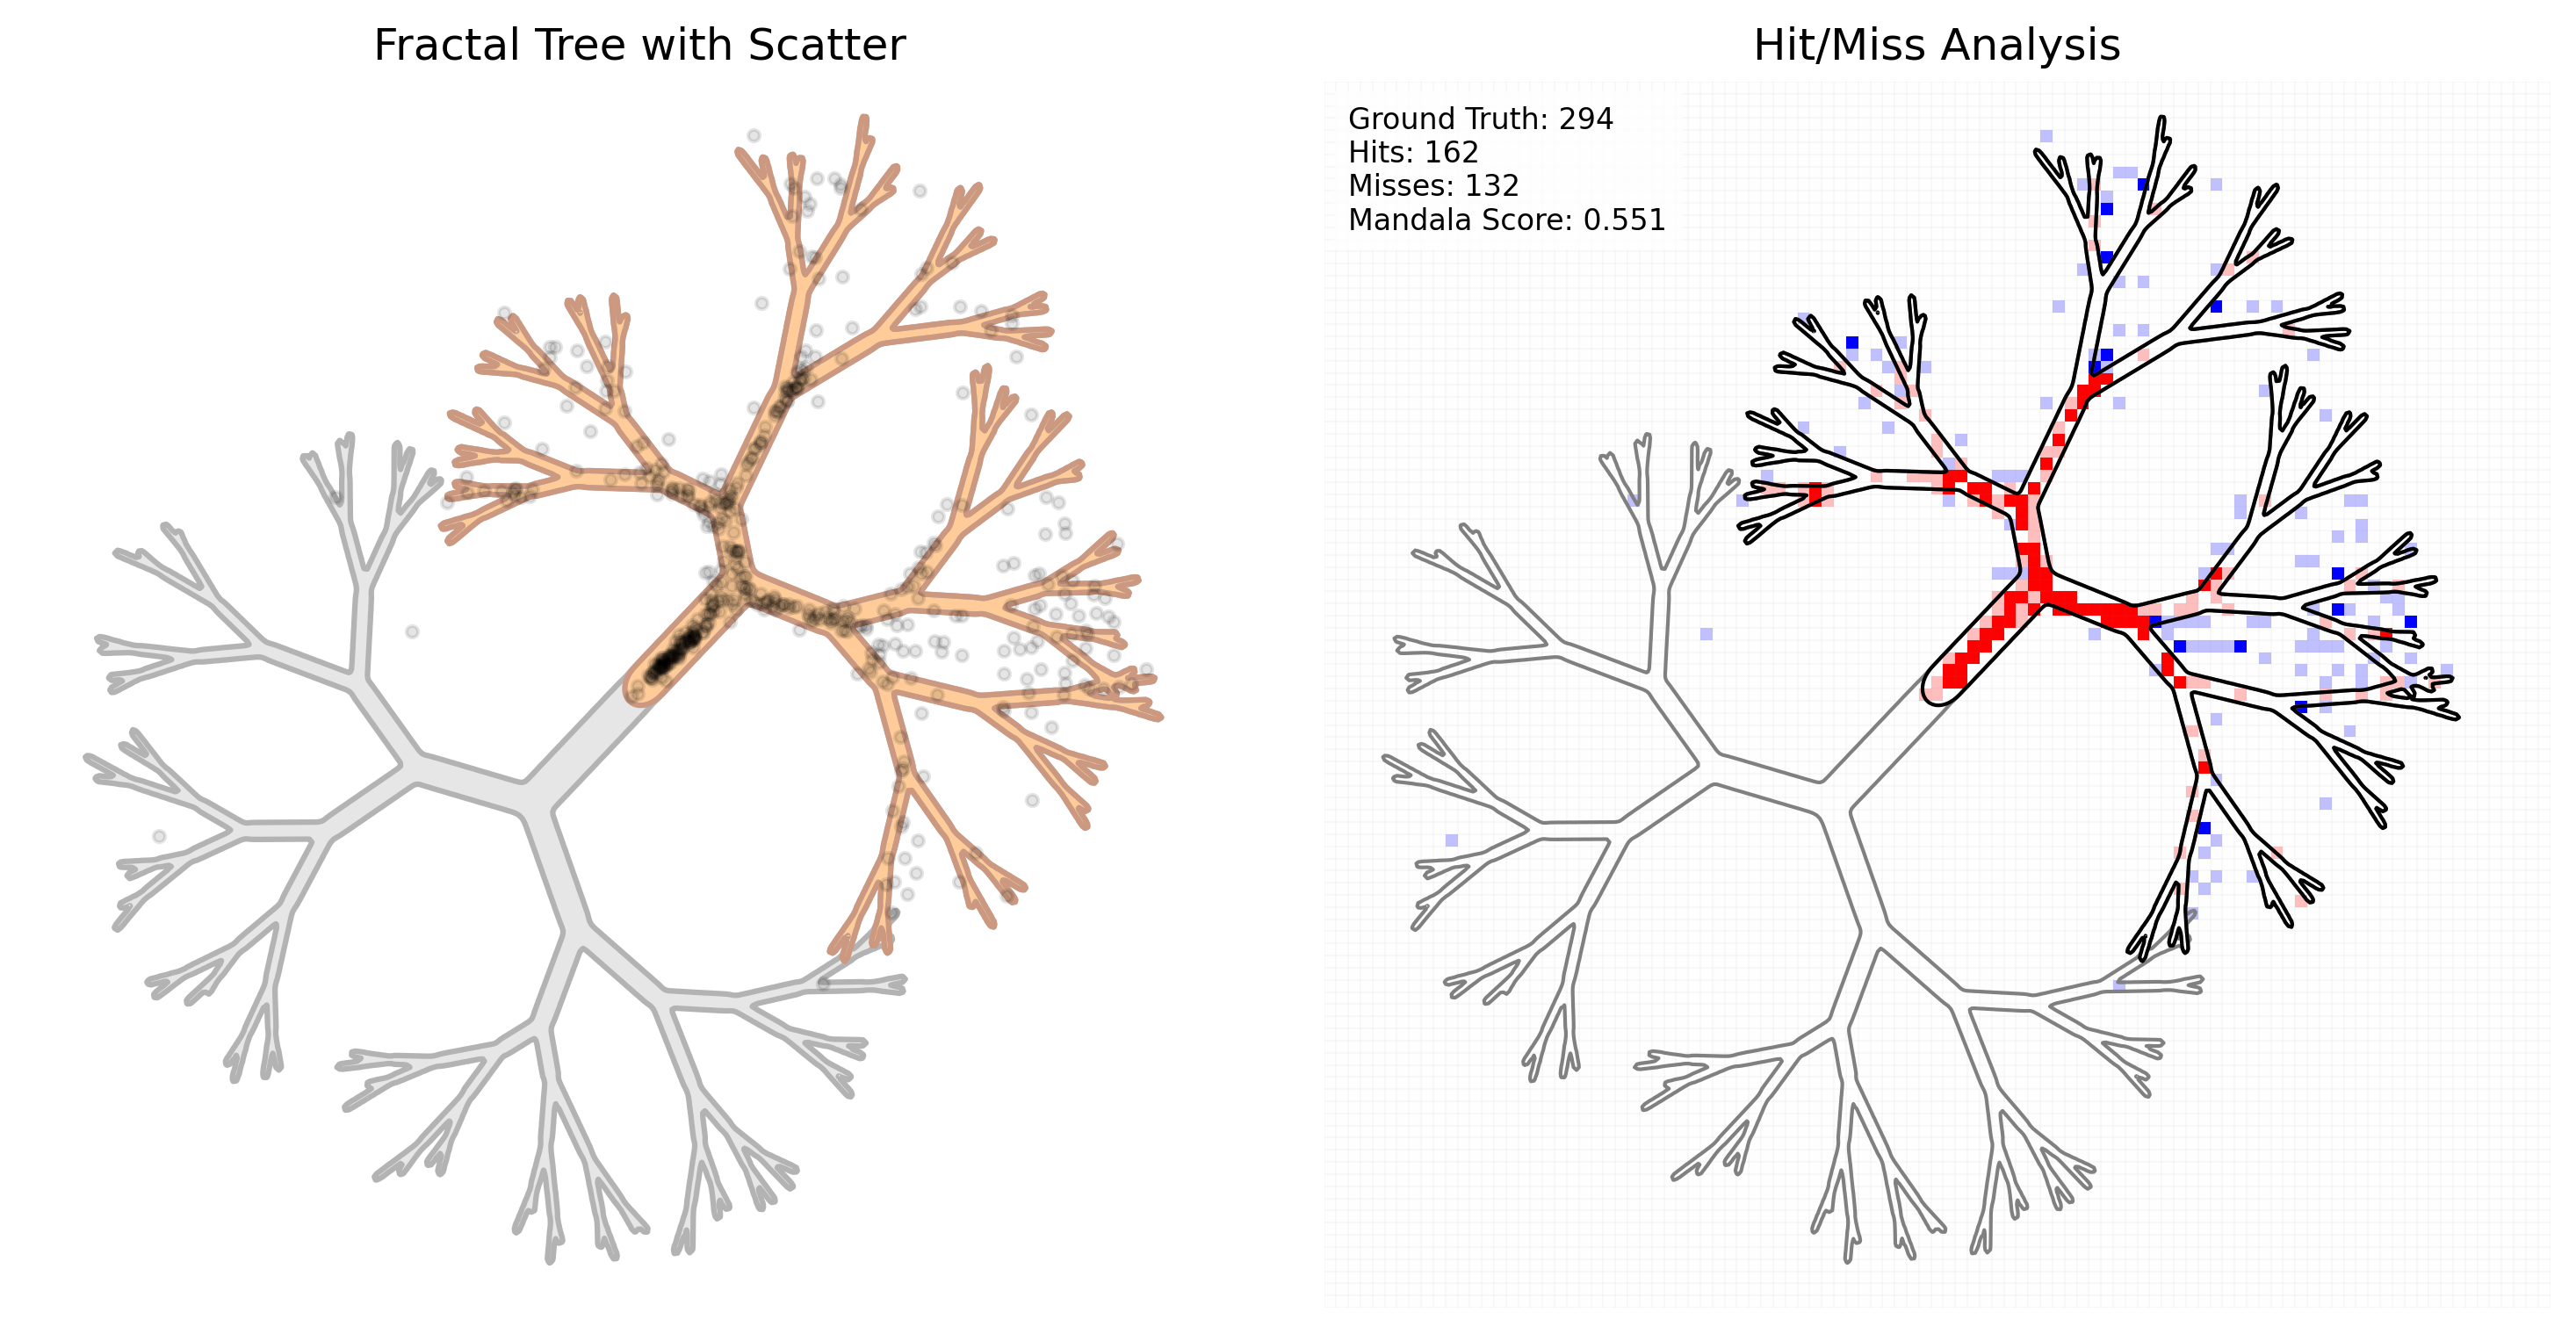

In [239]:
# Parameters
grid_resolution = 101
n_samples = 512

mandala_score(guide, gtd, n_samples=n_samples, sigma_max=sigma_max,
              grid_resolution=grid_resolution,
              logging=True, plotting=True, full_scale=False)
plt.savefig(os.path.join(dirs.RESULTS_HOME, 'fractal_analysis_guide_partial_2.png'), dpi=300, bbox_inches='tight')

### Ground truth test

### Test training checkpoints

In [281]:
# Parameters
grid_resolution = 101
n_samples = 2**16

series = ["InvertedGuideACID", "NoACIDGuided"]
series_names = ["ACID", "No ACID"]
get_checkpoints_path = lambda s : os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", s)

guidance_weight = [1, 3]
guidance_names = ["", "Guided "]

mandala_results = {}
non_unique_results = {}

for s, sn in zip(series, series_names):
    checkpoints_path = get_checkpoints_path(s)

    checkpoints = os.listdir(checkpoints_path)
    checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
    checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
    checkpoints.sort()
    checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
    n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

    for g, gn in zip(guidance_weight, guidance_names):

        these_mandala = []
        these_initial = []
        for iter, filepath in zip(n_iterations, checkpoints_filepaths):
            
            # Load checkpoint
            with builtins.open(filepath, "rb") as f:
                model = pickle.load(f).to(device)
            
            # Estimate
            mand_score, non_unique_score = mandala_score(
                model, gtd, guide=guide, guidance_weight=g,
                n_samples=n_samples, sigma_max=sigma_max,
                grid_resolution=grid_resolution,
                logging=True, plotting=False)
            these_mandala.append( mand_score )
            these_initial.append( non_unique_score )
        
        mandala_results[gn+sn] = these_mandala
        non_unique_results[gn+sn] = these_initial

Total in grid 65536 
> Hits 48917 
> Misses 16619
Initial score 0.7464141845703125
Unique total in grid 2479 
> Unique hits 795 
> Unique misses 1684
Mandala score 0.3206938281565147
Total in grid 65536 
> Hits 53264 
> Misses 12272
Initial score 0.812744140625
Unique total in grid 2370 
> Unique hits 821 
> Unique misses 1549
Mandala score 0.3464135021097046
Total in grid 65536 
> Hits 55126 
> Misses 10410
Initial score 0.841156005859375
Unique total in grid 2343 
> Unique hits 837 
> Unique misses 1506
Mandala score 0.35723431498079383
Total in grid 65536 
> Hits 55858 
> Misses 9678
Initial score 0.852325439453125
Unique total in grid 2249 
> Unique hits 842 
> Unique misses 1407
Mandala score 0.3743886171631836
Total in grid 65535 
> Hits 56838 
> Misses 8697
Initial score 0.867279052734375
Unique total in grid 2166 
> Unique hits 845 
> Unique misses 1321
Mandala score 0.39012003693444136
Total in grid 65536 
> Hits 57115 
> Misses 8421
Initial score 0.8715057373046875
Unique tot

#### 8192 samples

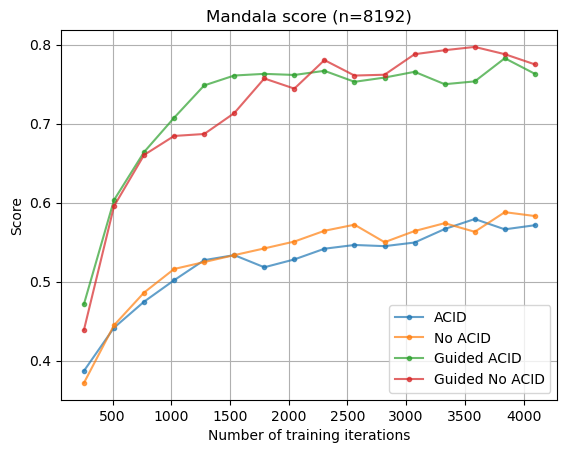

In [ ]:
plt.figure()
for gn in guidance_names:
    for sn in series_names:
        plt.plot(n_iterations, mandala_results[gn+sn], ".-", label=gn+sn, alpha=.7)
plt.ylabel("Score");
plt.xlabel("Number of training iterations");
plt.grid()
plt.legend()
plt.title(f"Mandala score (n={n_samples})");

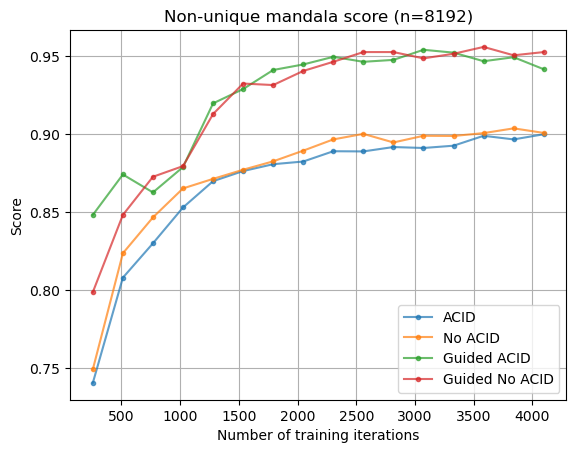

In [ ]:
plt.figure()
for gn in guidance_names:
    for sn in series_names:
        plt.plot(n_iterations, non_unique_results[gn+sn], ".-", label=gn+sn, alpha=.7)
plt.ylabel("Score");
plt.xlabel("Number of training iterations");
plt.grid()
plt.legend()
plt.title(f"Non-unique mandala score (n={n_samples})");

#### 16384 samples

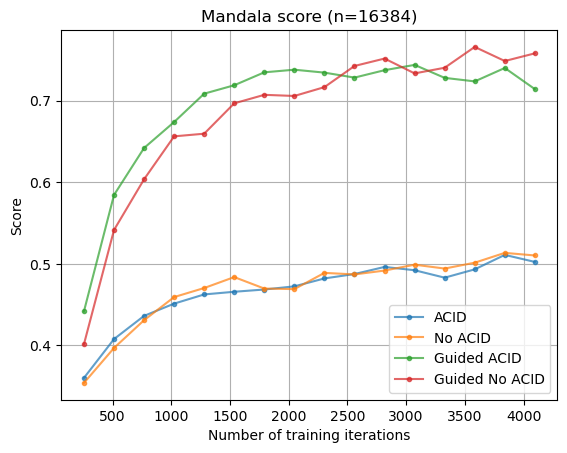

In [279]:
plt.figure()
for gn in guidance_names:
    for sn in series_names:
        plt.plot(n_iterations, mandala_results[gn+sn], ".-", label=gn+sn, alpha=.7)
plt.ylabel("Score");
plt.xlabel("Number of training iterations");
plt.grid()
plt.legend()
plt.title(f"Mandala score (n={n_samples})");

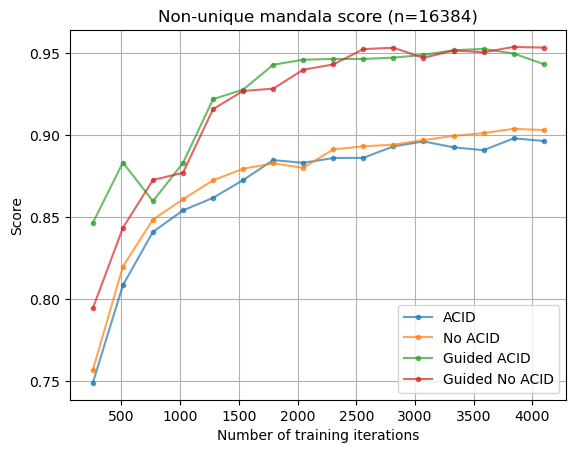

In [280]:
plt.figure()
for gn in guidance_names:
    for sn in series_names:
        plt.plot(n_iterations, non_unique_results[gn+sn], ".-", label=gn+sn, alpha=.7)
plt.ylabel("Score");
plt.xlabel("Number of training iterations");
plt.grid()
plt.legend()
plt.title(f"Non-unique mandala score (n={n_samples})");

#### 65536 samples

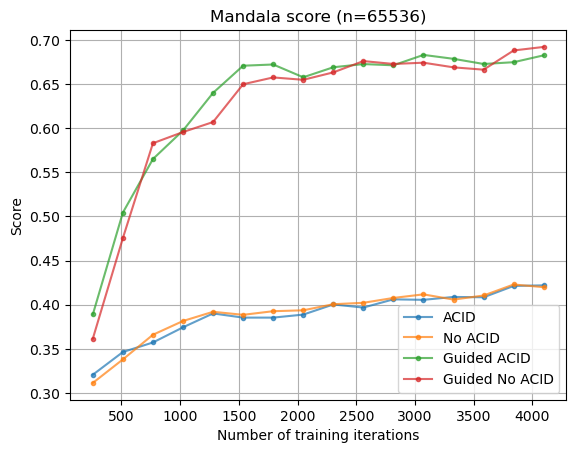

In [283]:
plt.figure()
for gn in guidance_names:
    for sn in series_names:
        plt.plot(n_iterations, mandala_results[gn+sn], ".-", label=gn+sn, alpha=.7)
plt.ylabel("Score");
plt.xlabel("Number of training iterations");
plt.grid()
plt.legend()
plt.title(f"Mandala score (n={n_samples})");

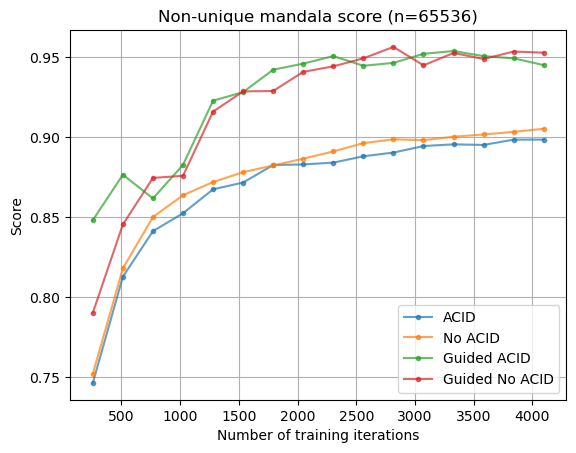

In [284]:
plt.figure()
for gn in guidance_names:
    for sn in series_names:
        plt.plot(n_iterations, non_unique_results[gn+sn], ".-", label=gn+sn, alpha=.7)
plt.ylabel("Score");
plt.xlabel("Number of training iterations");
plt.grid()
plt.legend()
plt.title(f"Non-unique mandala score (n={n_samples})");

### Test on fully trained model

In [49]:
# Parameters
grid_resolution = 101
n_samples = 2**16

series = ["Ref", "InvertedGuideACID", "NoACIDGuided"]
iters = [512, 4096, 4096]
get_checkpoints_filepath = lambda s, i : os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", s, f"iter{i:04d}.pkl")

mandala_results = []
initial_results = []

for s, i in zip(series, iters):
    checkpoints_path = get_checkpoints_filepath(s, i)

    checkpoints = os.listdir(checkpoints_path)
    checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
    checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
    checkpoints.sort()
    checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
    n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    
    # Estimate
    mand_score, initial_score = mandala_score(
        guide, gtd, 
        n_samples=n_samples, sigma_max=sigma_max,
        grid_resolution=grid_resolution,
        logging=True, plotting=True)
    plt.title(s)

    mandala_results.append( mand_score )
    initial_results.append( initial_score )

NotADirectoryError: [Errno 20] Not a directory: '/media/vale/QuickData/Vale/Training/models/SCID/ToyExample/10_EarlyStopACID/Ref/iter0512.pkl'